Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433

* https://www.kaggle.com/c/lish-moa/discussion/193878

* https://tsumit.hatenablog.com/entry/2020/06/20/044835

* https://www.kaggle.com/kushal1506/moa-pytorch-feature-engineering-0-01846

* https://www.kaggle.com/c/lish-moa/discussion/195195


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
# Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break
# Version = "v32" # y_prob.probability.quantile(0.3), if Threshold >= 0.95: break
# Version = "v33" # RankGauss, Scaled by category, SMOTE(k_neighbors=2),
# Version = "v34" # RankGauss apply c-columns, remove TOP100, Add f_diff = lambda x: x - med, Create features
# Version = "v35" # f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2, f_diff = lambda x: ((x-med)*10)**2, select features
# Version = "v36" # Add feature importance func
# Version = "v37" # Remove RankGauss for gene expression, fix feature importance func

Version = "v38" # Add MultiLabel Stratification func, fix index of data before split with "data = data.sort_index(axis='index')""

# Feature engineering based on Feature importance with v36 notebook

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("imblearn Version: ", imblearn.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)

lightgbm Version:  2.3.1
imblearn Version:  0.7.0
numpy Version:  1.18.5
pandas Version:  1.1.3


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

# New data file available from 3th November
drug = pd.read_csv('../input/lish-moa/train_drug.csv')

In [7]:
Targets = train_targets_scored.columns[1:]
Scored = train_targets_scored.merge(drug, on='sig_id', how='left')
Scored

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,drug_id
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,b68db1d53
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,df89a8e5a
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18bb41b2c
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8c7f86626
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7cbed3131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,df1d0a5a1
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ecf3b6b74
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,cacb2b860
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8b87a7a83


In [8]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    
    return train, test

In [9]:
# Manual annotation by myself
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

,sig_id,nonscored1,nonscored2
0,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN
1,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN
2,antiarrhythmic,na_k-atpase_inhibitor,potassium_channel_blocker
3,anticonvulsant,gaba_gated_chloride_channel_blocker,NaN
4,antifungal,fungal_ergosterol_inhibitor,fungal_lanosterol_demethylase_inhibitor
5,antihistamine,histamine_release_inhibitor,NaN
6,atp-sensitive_potassium_channel_antagonist,atp-sensitive_potassium_channel_inhibitor,NaN
7,bacterial_membrane_integrity_inhibitor,bacterial_protein_synthesis_inhibitor,NaN
8,calcineurin_inhibitor,t_cell_inhibitor,NaN
9,catechol_o_methyltransferase_inhibitor,dopamine_release_enhancer,NaN


In [10]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [11]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [12]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [13]:
def Multi_Stratification(df, target_col, target):
    
    _df = df.copy() 
    sig_id_lst = [list(Scored.sig_id[Scored.drug_id == id_].sample())[0] for id_ in Scored.drug_id.unique()]
    
    # Remove sig_id wih target 
    del_idx = train[target==1].sig_id.unique()
    select_idx = [i for i in sig_id_lst if i not in del_idx]
    print(f"neg labels: {len(sig_id_lst)}→ selected neg labels: {len(select_idx)}")
    
    # Select negative target
    _df = _df.set_index('sig_id')
    _df = _df.loc[select_idx, :]
    _df = _df.reset_index(drop=True)
    
    _df["target"] = 0
    
    return _df

In [69]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    # Estimate test target rate
    #target_rate *= (-0.001*target.sum()+1.1)
    Adj_target_rate =  (2 * target_rate)  / (target.sum()**0.15)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    
    logger.info(f"{target_col}, len(trt):{len(trt)}, target_rate:{target_rate:.7f} → Adj_target_rate:{Adj_target_rate:.7f}")
    
    othr =  Multi_Stratification(train, target_col, target)
        
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)   
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)

    sm = SMOTE(0.1, k_neighbors=3, n_jobs=2, random_state=SEED)
    X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y, feature_importance_df_ = pseudo_labeling(X_train, y_train, X_test, target_rate, target_col)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")
    
    return sum(y_preds) / len(y_preds), score, models, feature_importance_df_

In [70]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:,0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [71]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': 0.03,
    'objective': "binary",
    'colsample_bytree':0.4,
    'subsample':0.8,
    'subsample_freq':5,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2,
}

In [67]:
#===========================================================
# pseudo_labeling
#===========================================================

def pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    feature_importance_df = pd.DataFrame()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = X.columns
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
            
            # feature importance with target col
            _importance_df["importance"] = clf.feature_importances_
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        if iter_ == 1: Threshold = y_preds.iloc[:, 1].quantile(0.89)
            
        logger.info(f"Threshold: {Threshold}")
            
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        percentile = y_prob.probability.quantile(0.3)
        high_conf_0 = min(y_prob.probability.min()*30, percentile)
        high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
        logger.info(f"30th percentile: {percentile:.7f}")
        
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.7f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        
        if p_label_rate*3 < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if sum(p_label)*1.5 >= check: break 
                if (Threshold-0.005) < 0: break
                Threshold -= 0.005
                high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > target_rate*3:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if sum(p_label) <= check*1.5: break
                if (Threshold+0.005) > 0.99: break
                Threshold += 0.005
                high_conf_1 = max(y_prob.probability.max()*0.6,Threshold)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ == max_iter:
            X_conf = X_test.copy()
        else:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        logger.info(f"threshold:{Threshold:.7f}, positive p_label:{sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.7f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        logger.info(f"positive y_label:{sum(y)}/{len(y)}, y_label_rate: {sum(y)/len(y):.7f}")
        
    if DEBUG:
        show_feature_importance(feature_importance_df, target_col, num=10)
        
    return X, y, feature_importance_df

5-alpha_reductase_inhibitor, len(trt):17, target_rate:0.0007139→Adj_target_rate:0.0009334


neg labels: 3289→ selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135452	valid_1's binary_logloss: 0.0191472
[200]	training's binary_logloss: 0.00183751	valid_1's binary_logloss: 0.00483274
[300]	training's binary_logloss: 0.000619462	valid_1's binary_logloss: 0.00244618
[400]	training's binary_logloss: 0.000364677	valid_1's binary_logloss: 0.00178096
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000329967	valid_1's binary_logloss: 0.0016924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134128	valid_1's binary_logloss: 0.0251687
[200]	training's binary_logloss: 0.00177434	valid_1's binary_logloss: 0.0103178
[300]	training's binary_logloss: 0.000588688	valid_1's binary_logloss: 0.00808499


1 / 3 AUC score:1.000
Threshold: 0.0028936071142916997


Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000524937	valid_1's binary_logloss: 0.00792287


Remove_noisy_labels: 70 → positive_corect_labels: 328/3544
30th percentile: 0.0001332
p_label_rate: 0.0203415 Vs.target_rate: 0.00071, Num_p_label: 81.0, conf_0:0.00013, conf_1:0.25384
Num_p_label: 81.0, Expected: 2.8, Adj_threshold_1: 0.0028936
Num_p_label: 4.0, Expected: 2.8, Adj_threshold_2: 0.0428936
threshold:0.0428936, positive p_label:4.0/3982, p_label_rate: 0.0010045
positive y_label:328.0/3544, y_label_rate: 0.0925508
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137119	valid_1's binary_logloss: 0.0207253
[200]	training's binary_logloss: 0.00182282	valid_1's binary_logloss: 0.005684
[300]	training's binary_logloss: 0.000613737	valid_1's binary_logloss: 0.00319211
[400]	training's binary_logloss: 0.000359303	valid_1's binary_logloss: 0.00251998
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000340245	valid_1's binary_logloss: 0.00246295
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013438	valid_1's binary_logloss: 0.0251803
[200]	training's binary_logloss: 0.00173803	valid_1's binary_logloss: 0.00958552


2 / 3 AUC score:1.000
Threshold: 0.0428936071142917
Remove_noisy_labels: 2 → positive_corect_labels: 326.0/3542
30th percentile: 0.0001691
p_label_rate: 0.0015068 Vs.target_rate: 0.00071, Num_p_label: 6.0, conf_0:0.00017, conf_1:0.37133
threshold:0.0428936, positive p_label:6.0/3982, p_label_rate: 0.0015068


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000647369	valid_1's binary_logloss: 0.00775384


positive y_label:326.0/3542, y_label_rate: 0.0920384
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132411	valid_1's binary_logloss: 0.022991
[200]	training's binary_logloss: 0.00174334	valid_1's binary_logloss: 0.00780631
[300]	training's binary_logloss: 0.000586369	valid_1's binary_logloss: 0.00463795
[400]	training's binary_logloss: 0.000348146	valid_1's binary_logloss: 0.00363468
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00031287	valid_1's binary_logloss: 0.00348009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133666	valid_1's binary_logloss: 0.0188077
[200]	training's binary_logloss: 0.00171827	valid_1's binary_logloss: 0.00398344
[300]	training's binary_logloss: 0.000581714	valid_1's binary_logloss: 0.00182374
[400]	training's binary_logloss: 0.000351756	valid_1's binary_logloss: 0.00131856


3 / 3 AUC score:1.000
Threshold: 0.0428936071142917


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000311073	valid_1's binary_logloss: 0.00121136


Remove_noisy_labels: 0 → positive_corect_labels: 326.0/3542
30th percentile: 0.0000896
p_label_rate: 0.0010045 Vs.target_rate: 0.00071, Num_p_label: 4.0, conf_0:0.00009, conf_1:0.39892
threshold:0.0428936, positive p_label:4.0/3982, p_label_rate: 0.0010045
positive y_label:330.0/7524, y_label_rate: 0.0438596


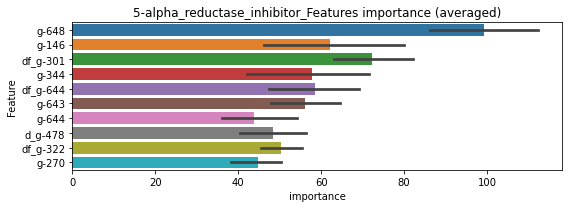

len(train_index) : 3762
len(valid_index) : 3762
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00649303	valid_1's binary_logloss: 0.0195198
[200]	training's binary_logloss: 0.000846135	valid_1's binary_logloss: 0.012958


len(train_index) : 3762
len(valid_index) : 3762


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.000391805	valid_1's binary_logloss: 0.011717


================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00640919	valid_1's binary_logloss: 0.0127781
[200]	training's binary_logloss: 0.000827386	valid_1's binary_logloss: 0.00480246
[300]	training's binary_logloss: 0.000280506	valid_1's binary_logloss: 0.00360585
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000176234	valid_1's binary_logloss: 0.00330738


5-alpha_reductase_inhibitor logloss: 0.007512191012065222
11-beta-hsd1_inhibitor, len(trt):18, target_rate:0.0007559→Adj_target_rate:0.0009799


neg labels: 3289→ selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165354	valid_1's binary_logloss: 0.0316597
[200]	training's binary_logloss: 0.00233086	valid_1's binary_logloss: 0.0110646
[300]	training's binary_logloss: 0.000763447	valid_1's binary_logloss: 0.00650142
[400]	training's binary_logloss: 0.000439987	valid_1's binary_logloss: 0.00530776
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000368928	valid_1's binary_logloss: 0.00493455
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166916	valid_1's binary_logloss: 0.0281535
[200]	training's binary_logloss: 0.00233176	valid_1's binary_logloss: 0.00763114
[300]	training's binary_logloss: 0.000760919	valid_1's binary_logloss: 0.00419317
[400]	training's binary_logloss: 0.000440472	valid_1's binary_logloss: 0.00332854
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000382552	valid_1's binary_logloss: 0.003158

1 / 3 AUC score:1.000
Threshold: 0.0030000928475512763
Remove_noisy_labels: 70 → positive_corect_labels: 328/3544
30th percentile: 0.0001207
p_label_rate: 0.0188348 Vs.target_rate: 0.00076, Num_p_label: 75.0, conf_0:0.00012, conf_1:0.01791
Num_p_label: 75.0, Expected: 3.0, Adj_threshold_1: 0.0030001
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_2: 0.0430001
threshold:0.0430001, positive p_label:0.0/3982, p_label_rate: 0.0000000
positive y_label:328.0/3544, y_label_rate: 0.0925508
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160231	valid_1's binary_logloss: 0.032151
[200]	training's binary_logloss: 0.00223659	valid_1's binary_logloss: 0.0118237
[300]	training's binary_logloss: 0.000740099	valid_1's binary_logloss: 0.00752002
[400]	training's binary_logloss: 0.000426615	valid_1's binary_logloss: 0.00598342
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000398976	valid_1's binary_logloss: 0.00585158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167961	valid_1's binary_logloss: 0.0267049
[200]	training's binary_logloss: 0.00234679	valid_1's binary_logloss: 0.00773743
[300]	training's binary_logloss: 0.000773839	valid_1's binary_logloss: 0.00402483
[400]	training's binary_logloss: 0.000445908	valid_1's binary_logloss: 0.00328437
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000413327	valid_1's binary_logloss: 0.0031500

2 / 3 AUC score:1.000
Threshold: 0.043000092847551276
Remove_noisy_labels: 1 → positive_corect_labels: 328.0/3543
30th percentile: 0.0001382
p_label_rate: 0.0010045 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.00014, conf_1:0.04300
threshold:0.0430001, positive p_label:4.0/3982, p_label_rate: 0.0010045
positive y_label:328.0/3543, y_label_rate: 0.0925769
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159847	valid_1's binary_logloss: 0.0331829
[200]	training's binary_logloss: 0.00224377	valid_1's binary_logloss: 0.0135625
[300]	training's binary_logloss: 0.000740126	valid_1's binary_logloss: 0.0089535
[400]	training's binary_logloss: 0.00043005	valid_1's binary_logloss: 0.00752387
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000391958	valid_1's binary_logloss: 0.00725329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165518	valid_1's binary_logloss: 0.027808
[200]	training's binary_logloss: 0.00231199	valid_1's binary_logloss: 0.00794811
[300]	training's binary_logloss: 0.000764085	valid_1's binary_logloss: 0.00424105
[400]	training's binary_logloss: 0.000441958	valid_1's binary_logloss: 0.00343202
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00041311	valid_1's binary_logloss: 0.00330965


3 / 3 AUC score:1.000
Threshold: 0.043000092847551276
Remove_noisy_labels: 0 → positive_corect_labels: 328.0/3543
30th percentile: 0.0001355
p_label_rate: 0.0005023 Vs.target_rate: 0.00076, Num_p_label: 2.0, conf_0:0.00014, conf_1:0.04300
threshold:0.0430001, positive p_label:2.0/3982, p_label_rate: 0.0005023
positive y_label:330.0/7525, y_label_rate: 0.0438538


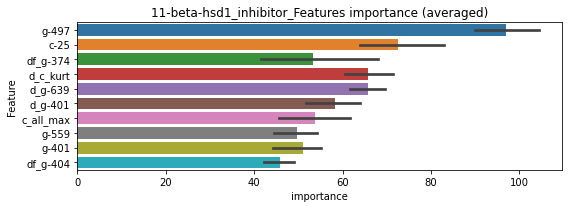

len(train_index) : 3762
len(valid_index) : 3763
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00837517	valid_1's binary_logloss: 0.0170526
[200]	training's binary_logloss: 0.00115896	valid_1's binary_logloss: 0.00816378


len(train_index) : 3763
len(valid_index) : 3762


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.000551612	valid_1's binary_logloss: 0.00734211


================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00835052	valid_1's binary_logloss: 0.0150263
[200]	training's binary_logloss: 0.00119011	valid_1's binary_logloss: 0.00542546
[300]	training's binary_logloss: 0.000375975	valid_1's binary_logloss: 0.00366339
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000246058	valid_1's binary_logloss: 0.00339916


11-beta-hsd1_inhibitor logloss: 0.005370900574502703
acat_inhibitor, len(trt):24, target_rate:0.0010078→Adj_target_rate:0.0012513


neg labels: 3289→ selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219726	valid_1's binary_logloss: 0.0403129
[200]	training's binary_logloss: 0.00332899	valid_1's binary_logloss: 0.0128994
[300]	training's binary_logloss: 0.00106364	valid_1's binary_logloss: 0.00707104
[400]	training's binary_logloss: 0.000576954	valid_1's binary_logloss: 0.00544064
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000529638	valid_1's binary_logloss: 0.00527676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213812	valid_1's binary_logloss: 0.0442957
[200]	training's binary_logloss: 0.00344318	valid_1's binary_logloss: 0.0146807
[300]	training's binary_logloss: 0.00108729	valid_1's binary_logloss: 0.00814334
[400]	training's binary_logloss: 0.000575235	valid_1's binary_logloss: 0.00607786
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000514504	valid_1's binary_logloss: 0.005989


1 / 3 AUC score:1.000
Threshold: 0.002842034744329916
Remove_noisy_labels: 70 → positive_corect_labels: 328/3543
30th percentile: 0.0002338
p_label_rate: 0.0215972 Vs.target_rate: 0.00101, Num_p_label: 86.0, conf_0:0.00023, conf_1:0.01275
Num_p_label: 86.0, Expected: 4.0, Adj_threshold_1: 0.0028420
Num_p_label: 0.0, Expected: 4.0, Adj_threshold_2: 0.0428420
threshold:0.0428420, positive p_label:0.0/3982, p_label_rate: 0.0000000
positive y_label:328.0/3543, y_label_rate: 0.0925769
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021786	valid_1's binary_logloss: 0.0377256
[200]	training's binary_logloss: 0.00341752	valid_1's binary_logloss: 0.0113919
[300]	training's binary_logloss: 0.00107965	valid_1's binary_logloss: 0.00613588
[400]	training's binary_logloss: 0.000577734	valid_1's binary_logloss: 0.00474877
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000472139	valid_1's binary_logloss: 0.00441528
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204355	valid_1's binary_logloss: 0.0429225
[200]	training's binary_logloss: 0.00325726	valid_1's binary_logloss: 0.0137834
[300]	training's binary_logloss: 0.00105351	valid_1's binary_logloss: 0.00734434


2 / 3 AUC score:1.000
Threshold: 0.04284203474432992


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000756378	valid_1's binary_logloss: 0.0063642


Remove_noisy_labels: 0 → positive_corect_labels: 328.0/3543
30th percentile: 0.0002838
p_label_rate: 0.0002511 Vs.target_rate: 0.00101, Num_p_label: 1.0, conf_0:0.00028, conf_1:0.04284
Num_p_label: 1.0, Expected: 4.0, Adj_threshold_1: 0.0428420
threshold:0.0028420, positive p_label:1.0/3982, p_label_rate: 0.0002511
positive y_label:328.0/3543, y_label_rate: 0.0925769
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021786	valid_1's binary_logloss: 0.0377256
[200]	training's binary_logloss: 0.00341752	valid_1's binary_logloss: 0.0113919
[300]	training's binary_logloss: 0.00107965	valid_1's binary_logloss: 0.00613588
[400]	training's binary_logloss: 0.000577734	valid_1's binary_logloss: 0.00474877
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000472139	valid_1's binary_logloss: 0.00441528
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204355	valid_1's binary_logloss: 0.0429225
[200]	training's binary_logloss: 0.00325726	valid_1's binary_logloss: 0.0137834
[300]	training's binary_logloss: 0.00105351	valid_1's binary_logloss: 0.00734434


3 / 3 AUC score:1.000
Threshold: 0.0028420347443299174


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000756378	valid_1's binary_logloss: 0.0063642


Remove_noisy_labels: 89 → positive_corect_labels: 328.0/3454
30th percentile: 0.0002838
p_label_rate: 0.0356605 Vs.target_rate: 0.00101, Num_p_label: 142.0, conf_0:0.00028, conf_1:0.03186
Num_p_label: 142.0, Expected: 4.0, Adj_threshold_1: 0.0028420
Num_p_label: 1.0, Expected: 4.0, Adj_threshold_2: 0.0428420
threshold:0.0428420, positive p_label:1.0/3982, p_label_rate: 0.0002511
positive y_label:329.0/7436, y_label_rate: 0.0442442


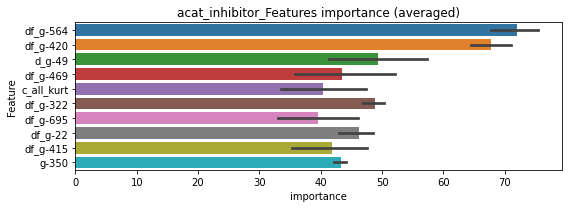

len(train_index) : 3718
len(valid_index) : 3718
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104446	valid_1's binary_logloss: 0.0200541
[200]	training's binary_logloss: 0.00157964	valid_1's binary_logloss: 0.00704974
[300]	training's binary_logloss: 0.000490561	valid_1's binary_logloss: 0.00452111
[400]	training's binary_logloss: 0.000265756	valid_1's binary_logloss: 0.00386762
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000240211	valid_1's binary_logloss: 0.00374949


len(train_index) : 3718
len(valid_index) : 3718
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107119	valid_1's binary_logloss: 0.0190614
[200]	training's binary_logloss: 0.00170319	valid_1's binary_logloss: 0.00680461
[300]	training's binary_logloss: 0.000530666	valid_1's binary_logloss: 0.00425386
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000307914	valid_1's binary_logloss: 0.00331397


acat_inhibitor logloss: 0.003531729592869254
acetylcholine_receptor_agonist, len(trt):190, target_rate:0.0079785→Adj_target_rate:0.0072634


neg labels: 3289→ selected neg labels: 3259


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0649045	valid_1's binary_logloss: 0.234036
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0485675	valid_1's binary_logloss: 0.228998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623978	valid_1's binary_logloss: 0.244025


1 / 3 AUC score:0.815
Threshold: 0.07858107329055186
Remove_noisy_labels: 368 → positive_corect_labels: 176/3216
30th percentile: 0.0230493
p_label_rate: 0.0539930 Vs.target_rate: 0.00798, Num_p_label: 215.0, conf_0:0.02305, conf_1:0.09758
Num_p_label: 215.0, Expected: 31.8, Adj_threshold_1: 0.0785811
Num_p_label: 28.0, Expected: 31.8, Adj_threshold_2: 0.1185811
threshold:0.1185811, positive p_label:28.0/3982, p_label_rate: 0.0070316


Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0452594	valid_1's binary_logloss: 0.242474


positive y_label:176.0/3216, y_label_rate: 0.0547264
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258081	valid_1's binary_logloss: 0.14341
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.0224373	valid_1's binary_logloss: 0.142834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026407	valid_1's binary_logloss: 0.147177


2 / 3 AUC score:0.902
Threshold: 0.11858107329055187
Remove_noisy_labels: 100 → positive_corect_labels: 76.0/3116
30th percentile: 0.0099862
p_label_rate: 0.0002511 Vs.target_rate: 0.00798, Num_p_label: 1.0, conf_0:0.00999, conf_1:0.11858
Num_p_label: 1.0, Expected: 31.8, Adj_threshold_1: 0.1185811
threshold:0.0785811, positive p_label:1.0/3982, p_label_rate: 0.0002511


Early stopping, best iteration is:
[102]	training's binary_logloss: 0.0255504	valid_1's binary_logloss: 0.147079


positive y_label:76.0/3116, y_label_rate: 0.0243902
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.0146876	valid_1's binary_logloss: 0.0704778
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.877
Threshold: 0.07858107329055186
Remove_noisy_labels: 42 → positive_corect_labels: 34.0/3074
30th percentile: 0.0048005
p_label_rate: 0.0000000 Vs.target_rate: 0.00798, Num_p_label: 0.0, conf_0:0.00480, conf_1:0.07858
Num_p_label: 0.0, Expected: 31.8, Adj_threshold_1: 0.0785811
threshold:0.0385811, positive p_label:0.0/3982, p_label_rate: 0.0000000


Early stopping, best iteration is:
[79]	training's binary_logloss: 0.0120071	valid_1's binary_logloss: 0.0841502


positive y_label:34.0/7056, y_label_rate: 0.0048186


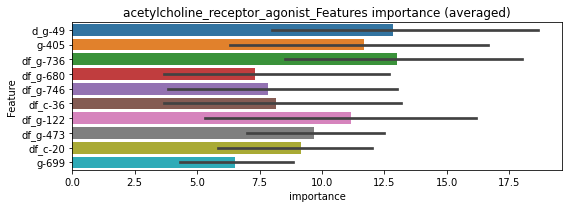

len(train_index) : 3528
len(valid_index) : 3528
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00151433	valid_1's binary_logloss: 0.0136231


len(train_index) : 3528
len(valid_index) : 3528
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Early stopping, best iteration is:
[120]	training's binary_logloss: 0.00100265	valid_1's binary_logloss: 0.0129077
Training until validation scores don't improve for 10 rounds


acetylcholine_receptor_agonist logloss: 0.01328063959734726


[100]	training's binary_logloss: 0.00132936	valid_1's binary_logloss: 0.0137801
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.00144165	valid_1's binary_logloss: 0.0136535


acetylcholine_receptor_antagonist, len(trt):301, target_rate:0.0126396→Adj_target_rate:0.0107394


neg labels: 3289→ selected neg labels: 3241


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.161667	valid_1's binary_logloss: 0.299128
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.569
Threshold: 0.11014992936981466
Remove_noisy_labels: 617 → positive_corect_labels: 50/2948
30th percentile: 0.0718249
p_label_rate: 0.0630337 Vs.target_rate: 0.01264, Num_p_label: 251.0, conf_0:0.07182, conf_1:0.11015
Num_p_label: 251.0, Expected: 50.3, Adj_threshold_1: 0.1101499
Num_p_label: 3.0, Expected: 50.3, Adj_threshold_2: 0.1501499
threshold:0.1501499, positive p_label:3.0/3982, p_label_rate: 0.0007534


Early stopping, best iteration is:
[24]	training's binary_logloss: 0.199686	valid_1's binary_logloss: 0.299656


positive y_label:50.0/2948, y_label_rate: 0.0169607
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.0266438	valid_1's binary_logloss: 0.0800122
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.576
Threshold: 0.15014992936981467
Remove_noisy_labels: 44 → positive_corect_labels: 6.0/2904
30th percentile: 0.0084819
p_label_rate: 0.0000000 Vs.target_rate: 0.01264, Num_p_label: 0.0, conf_0:0.00848, conf_1:0.15015
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_1: 0.1501499
threshold:0.1101499, positive p_label:0.0/3982, p_label_rate: 0.0000000


Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0254114	valid_1's binary_logloss: 0.0805699


positive y_label:6.0/2904, y_label_rate: 0.0020661
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.00471798	valid_1's binary_logloss: 0.0109034
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.00437687	valid_1's binary_logloss: 0.012341


3 / 3 AUC score:0.924
Threshold: 0.11014992936981466
Remove_noisy_labels: 6 → positive_corect_labels: 0.0/2898
30th percentile: 0.0010547
p_label_rate: 0.0000000 Vs.target_rate: 0.01264, Num_p_label: 0.0, conf_0:0.00105, conf_1:0.11015
Num_p_label: 0.0, Expected: 50.3, Adj_threshold_1: 0.1101499
threshold:0.0701499, positive p_label:0.0/3982, p_label_rate: 0.0000000
positive y_label:0.0/6880, y_label_rate: 0.0000000


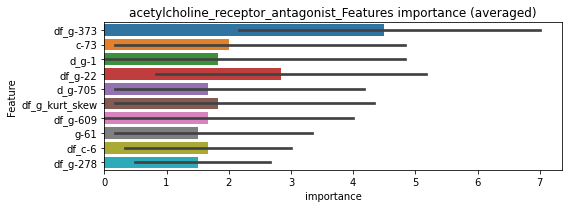

len(train_index) : 3440
len(valid_index) : 3440
================================= fold 1/2 acetylcholine_receptor_antagonist=================================
len(train_index) : 3440
len(valid_index) : 3440
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0	valid_1's binary_logloss: 0
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0	valid_1's binary_logloss: 0



ValueError: y_true contains only one label (0.0). Please provide the true labels explicitly through the labels argument.

In [68]:
categorical_cols = []
feature_importance_df = pd.DataFrame()
importance_cols_df = pd.DataFrame()
scores = []
models = []

for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models, _feature_importance_df = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    if DEBUG:
        if _score > 0.02:
            importance_cols_df[target_col] = select_importance_cols(_feature_importance_df)
            print(importance_cols_df)
        
        feature_importance_df = create_featureimprotance(models, feature_importance_df)

In [18]:
def show_feature_importance(feature_importance_df, title="all", num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    hight = int(num//3.3)
    plt.figure(figsize=(8, hight))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f'{title}_Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./{title}_feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [19]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [20]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [21]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [22]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [23]:
# Select control data
ctl = train[(train.cp_type==0)].copy()
ctl = ctl.reset_index(drop=True)
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
2,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
3,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
4,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
1862,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
1863,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
1864,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [24]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [25]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in tqdm(data.cp_time.unique()):
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']): Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        
        f_div = lambda x: ((x+d)*10 / (abs(med)+d))**3
        select_div = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select, select_div], axis=1, sort=False)
        
        
        f_diff = lambda x: ((x-med)*10)**2
        select_diff = select.iloc[:,4:].apply(f_diff, axis=1).add_prefix('df_')
        tmp_data = pd.concat([tmp_data, select_diff], axis=1, sort=False)
        
        data_df = pd.concat([data_df, tmp_data], axis=0)
        
data_df

4534
4538
4561
4536
5079
4548



,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,df_c-90,df_c-91,df_c-92,df_c-93,df_c-94,df_c-95,df_c-96,df_c-97,df_c-98,df_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.099225,0.289444,38.626225,1.731856,43.046721,10.086976,59.861169,1.567504,0.147456,0.216225
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,231.435369,71.368704,143.544361,219.128809,92.563641,1.234321,69.956496,0.139876,19.633761,105.657841
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,90.897156,22.667121,7.360369,7.667361,20.848356,16.777216,2.762244,25.160256,0.050176,1.223236
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,49.801249,99.002500,71.487025,39.062500,1.162084,22.344529,2.461761,7.043716,9.492561,343.397961
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,1050.861889,3701.748964,450.330841,1093.426489,1045.164241,797.949504,947.162176,671.898241,2680.857729,103.469584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,18.974736,70.711281,1.157776,24.830289,10.784656,35.640900,6.702921,49.942489,0.300304,60.497284
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,199.430884,72.539289,1238.336100,106.357969,3121.009956,194.435136,651.168324,170.485249,759.443364,248.755984
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,0.722500,0.222784,20.007729,47.444544,46.090521,100.220121,3.101121,0.405769,616.429584,43.086096
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,135.117376,64.192144,6.990736,124.478649,76.160529,290.838916,272.514064,151.659225,177.102864,207.994084


In [26]:
# clipping
clipping = data_df.columns[4:]
for col in tqdm(clipping):
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,df_c-90,df_c-91,df_c-92,df_c-93,df_c-94,df_c-95,df_c-96,df_c-97,df_c-98,df_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.099225,0.289444,38.626225,1.731856,43.046721,10.086976,59.861169,1.567504,0.147456,0.216225
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,231.435369,71.368704,143.544361,219.128809,92.563641,1.234321,69.956496,0.139876,19.633761,105.657841
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,90.897156,22.667121,7.360369,7.667361,20.848356,16.777216,2.762244,25.160256,0.050176,1.223236
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,49.801249,99.002500,71.487025,39.062500,1.162084,22.344529,2.461761,7.043716,9.492561,343.397961
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,1050.861889,3701.748964,450.330841,1093.426489,1045.164241,797.949504,947.162176,671.898241,2680.857729,103.469584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,18.974736,70.711281,1.157776,24.830289,10.784656,35.640900,6.702921,49.942489,0.300304,60.497284
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,199.430884,72.539289,1238.336100,106.357969,3121.009956,194.435136,651.168324,170.485249,759.443364,248.755984
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,0.722500,0.222784,20.007729,47.444544,46.090521,100.220121,3.101121,0.405769,616.429584,43.086096
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,135.117376,64.192144,6.990736,124.478649,76.160529,290.838916,272.514064,151.659225,177.102864,207.994084


In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data = data_df.copy()

In [28]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]
df_g_list = [col for col in data.columns[4:] if col.startswith("df_g-")]
df_c_list = [col for col in data.columns[4:] if col.startswith("df_c-")]
g_all_list = g_list + d_g_list + df_g_list
c_all_list = c_list + d_c_list + df_c_list

In [29]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
    
# Z-score
#scaler = StandardScaler(with_mean=True, with_std=True)

# RankGauss
scaler = QuantileTransformer(output_distribution='normal', random_state=SEED)
size = len(data[col].values)

# Without Z-scored gene expression data
for col in tqdm(data.columns[4+len(g_list):]):
    
    raw = data[col].values.reshape(size, 1)
    scaler.fit(raw)

    data[col] = scaler.transform(raw).reshape(1, size)[0]
    
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,df_c-90,df_c-91,df_c-92,df_c-93,df_c-94,df_c-95,df_c-96,df_c-97,df_c-98,df_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,-1.810818,-1.556684,0.248606,-1.083179,0.184056,-0.422826,0.452858,-1.087786,-1.717424,-1.652775
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,1.204512,0.578443,1.006571,1.139912,0.620313,-1.168574,0.544603,-1.732771,-0.122754,0.767287
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,0.722254,-0.057595,-0.552164,-0.559241,-0.181398,-0.197771,-0.918947,0.003369,-1.947569,-1.204362
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,0.374101,0.776318,0.609079,0.186897,-1.233969,-0.059989,-0.958117,-0.570161,-0.453190,1.387738
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,1.545960,1.713131,1.361963,1.543328,1.492319,1.588429,1.517699,1.513423,1.721750,0.753663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-0.147978,0.572841,-1.187832,-0.046089,-0.472173,0.185676,-0.600581,0.372026,-1.536801,0.434025
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,1.145838,0.589930,1.501425,0.751316,1.638799,1.135045,1.459280,1.082334,1.356379,1.247627
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,-1.310017,-1.616881,-0.099856,0.290319,0.222431,0.772244,-0.884043,-1.473699,1.308167,0.237404
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,0.949547,0.513294,-0.572693,0.836947,0.502350,1.305647,1.236926,1.021927,0.945616,1.153026


In [30]:
std_df = data.iloc[:, 4:].copy()

In [31]:
data_df.cp_type = data_df.cp_type.astype('int16')
data_df.cp_time = data_df.cp_time.astype('int16')
data_df.cp_dose = data_df.cp_dose.astype('int16')

In [32]:
from sklearn.cluster import KMeans

n_clusters = 7

def create_cluster(data, features, kind, n_clusters):
    
    data_ = data[features].copy()
    kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data_)
    data[f'clusters_{kind}'] = kmeans.labels_[:data.shape[0]]
 
    return data


def detect_cluster(data, feature_list, kind_list, n_clusters):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = create_cluster(data, feature, kind=kind_list[idx], n_clusters=n_clusters)
    
    clusters = data.iloc[:, -len(feature_list):].copy()
    
    return clusters

In [33]:
feature_list = (g_list, c_list, d_g_list, d_c_list, df_g_list, df_c_list, g_all_list, c_all_list)
kind_list = ('g', 'c', 'd_g', 'd_c', 'df_g', 'df_c', 'g_all', 'c_all')


clusters = detect_cluster(data, feature_list, kind_list, n_clusters)
clusters

,clusters_g,clusters_c,clusters_d_g,clusters_d_c,clusters_df_g,clusters_df_c,clusters_g_all,clusters_c_all
0,6,2,5,4,1,2,0,0
5,0,3,3,0,6,1,4,5
36,0,2,5,4,6,2,0,0
38,3,0,2,6,1,4,4,2
39,5,5,1,1,2,0,6,1
...,...,...,...,...,...,...,...,...
27754,6,0,4,6,1,4,0,2
27759,4,5,1,1,0,0,2,1
27768,6,0,4,4,3,4,0,2
27784,3,4,5,1,3,1,3,3


In [34]:
# Count cluster types
for i in tqdm(range(n_clusters-1, -1, -1)):
    clusters[f"cnt_{i}"] = clusters.apply(lambda x: (x == i).sum(), axis=1)
clusters

,clusters_g,clusters_c,clusters_d_g,clusters_d_c,clusters_df_g,clusters_df_c,clusters_g_all,clusters_c_all,cnt_6,cnt_5,cnt_4,cnt_3,cnt_2,cnt_1,cnt_0
0,6,2,5,4,1,2,0,0,1,1,1,0,2,4,3
5,0,3,3,0,6,1,4,5,1,1,1,2,1,5,2
36,0,2,5,4,6,2,0,0,1,1,1,0,2,3,4
38,3,0,2,6,1,4,4,2,1,0,2,1,3,3,2
39,5,5,1,1,2,0,6,1,1,2,0,0,2,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,6,0,4,6,1,4,0,2,2,0,2,0,3,1,4
27759,4,5,1,1,0,0,2,1,0,1,1,0,1,6,4
27768,6,0,4,4,3,4,0,2,1,0,3,2,2,1,3
27784,3,4,5,1,3,1,3,3,0,1,1,4,0,4,2


In [35]:
def fe_stats(df, features, kind):
    df_ = df.copy()
    MAX, MIN = df_[features].max(axis = 1), df_[features].min(axis = 1)
    Kurt = df_[features].kurtosis(axis = 1)
    Skew = df_[features].skew(axis = 1)
    
    df_[f'{kind}_max'] = MAX
    df_[f'{kind}_min'] = MIN
    df_[f'{kind}_max_min'] = (MAX * MIN)**2
    
    df_[f'{kind}_kurt'] = Kurt**3
    df_[f'{kind}_skew'] = Skew**3
    df_[f'{kind}_max_kurt'] = MAX * Kurt
    df_[f'{kind}_max_skew'] = MAX * Skew
    df_[f'{kind}_kurt_skew'] = Kurt * Skew
    
    df_[f'{kind}_sum'] = (df_[features].sum(axis = 1))**3
    df_[f'{kind}_mean'] = (df_[features].mean(axis = 1))**3
    df_[f'{kind}_median'] = (df_[features].median(axis = 1))**3
    df_[f'{kind}_mad'] = (df_[features].mad(axis = 1))**3
    df_[f'{kind}_std'] = (df_[features].std(axis = 1))**3

    return df_

def detect_stats(data, feature_list, kind_list):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = fe_stats(data, feature, kind=kind_list[idx])

    stats = data.iloc[:, -9*len(feature_list):].copy()
    
    return stats

In [36]:
stats = detect_stats(data, feature_list, kind_list)
stats

,d_g_max_skew,d_g_kurt_skew,d_g_sum,d_g_mean,d_g_median,d_g_mad,d_g_std,d_c_max,d_c_min,d_c_max_min,...,c_all_kurt,c_all_skew,c_all_max_kurt,c_all_max_skew,c_all_kurt_skew,c_all_sum,c_all_mean,c_all_median,c_all_mad,c_all_std
0,1.773997,1.122617,-1.278176e+03,-2.778042e-06,-0.000164,0.421547,0.921185,1.479033,-0.843085,1.554884,...,702.924851,-6.600307,19.580500,-4.130876,-16.678526,1.200612e+04,4.446710e-04,6.841772e-03,0.288784,0.812540
5,-0.810013,-0.668520,4.686249e+04,1.018529e-04,0.000493,0.450344,1.019499,1.859501,-0.862363,2.571423,...,119.845739,1.274329,25.634344,5.636921,5.345251,2.433312e+07,9.012267e-01,7.215851e-01,0.573522,2.324385
36,0.774587,0.831640,2.368342e+02,5.147454e-07,-0.000019,0.460320,1.141932,0.980110,-1.090500,1.142353,...,1105.732838,-9.744666,16.710012,-3.451562,-22.087118,-6.350024e+02,-2.351861e-05,8.186017e-05,0.246688,0.682099
38,0.607893,0.323852,1.909071e+03,4.149255e-06,0.000007,0.553510,1.126814,1.185165,-1.179324,1.953547,...,0.012519,-0.001557,0.421912,-0.210613,-0.026914,-3.831963e+04,-1.419245e-03,-9.070147e-04,0.130688,0.284034
39,-0.867726,-0.279692,1.404200e+04,3.051948e-05,0.001977,2.540625,5.120534,-0.393566,-1.898526,0.558301,...,-3.218037,0.276399,-2.778375,1.225855,-0.961706,-1.693883e+06,-6.273639e-02,-1.606729e+00,2.088183,2.623831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,1.124029,0.487651,-4.176693e+03,-9.077801e-06,-0.000059,0.459287,0.896787,1.800581,-1.739289,9.807738,...,29.828422,-0.219709,6.451519,-1.255263,-1.871369,-5.882616e+04,-2.178747e-03,-5.373233e-04,0.333428,0.633158
27759,-0.603212,-0.187947,-3.668553e+05,-7.973389e-04,-0.001380,1.934329,3.692947,0.980837,-2.611712,6.562119,...,-2.327266,0.186799,-2.454153,1.058631,-0.757543,-2.156482e+06,-7.986971e-02,-1.098727e+00,1.533818,2.067397
27768,2.355228,1.710186,1.291874e+02,2.807813e-07,-0.000040,0.862901,1.992174,2.611712,-1.468736,14.714241,...,270.636976,-3.786773,16.893553,-4.070818,-10.082126,-5.987463e+03,-2.217579e-04,-1.400804e-07,0.521840,1.280537
27784,-0.465225,-0.172956,-6.489317e+04,-1.410416e-04,-0.000112,0.540292,1.000059,1.177806,-2.101746,6.127853,...,3.647902,0.000002,2.470916,0.021522,0.020641,-9.736824e+05,-3.606231e-02,-2.744378e-01,0.443372,0.740543


In [37]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], clusters], axis=1)
data = pd.concat([data, stats], axis=1)
data = pd.concat([data, std_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,clusters_g,clusters_c,clusters_d_g,clusters_d_c,clusters_df_g,clusters_df_c,...,df_c-90,df_c-91,df_c-92,df_c-93,df_c-94,df_c-95,df_c-96,df_c-97,df_c-98,df_c-99
0,id_000644bb2,1,0,0,6,2,5,4,1,2,...,-1.810818,-1.556684,0.248606,-1.083179,0.184056,-0.422826,0.452858,-1.087786,-1.717424,-1.652775
5,id_001762a82,1,0,0,0,3,3,0,6,1,...,1.204512,0.578443,1.006571,1.139912,0.620313,-1.168574,0.544603,-1.732771,-0.122754,0.767287
36,id_00762e877,1,0,0,0,2,5,4,6,2,...,0.722254,-0.057595,-0.552164,-0.559241,-0.181398,-0.197771,-0.918947,0.003369,-1.947569,-1.204362
38,id_0079af0fb,0,0,0,3,0,2,6,1,4,...,0.374101,0.776318,0.609079,0.186897,-1.233969,-0.059989,-0.958117,-0.570161,-0.453190,1.387738
39,id_0079d45d3,1,0,0,5,5,1,1,2,0,...,1.545960,1.713131,1.361963,1.543328,1.492319,1.588429,1.517699,1.513423,1.721750,0.753663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,6,0,4,6,1,4,...,-0.147978,0.572841,-1.187832,-0.046089,-0.472173,0.185676,-0.600581,0.372026,-1.536801,0.434025
27759,id_fce497048,1,1,1,4,5,1,1,0,0,...,1.145838,0.589930,1.501425,0.751316,1.638799,1.135045,1.459280,1.082334,1.356379,1.247627
27768,id_fd75349b2,1,1,1,6,0,4,4,3,4,...,-1.310017,-1.616881,-0.099856,0.290319,0.222431,0.772244,-0.884043,-1.473699,1.308167,0.237404
27784,id_fed0f2fe0,1,1,1,3,4,5,1,3,1,...,0.949547,0.513294,-0.572693,0.836947,0.502350,1.305647,1.236926,1.021927,0.945616,1.153026


In [38]:
# Create feature
import itertools
def CreateFeat(df):
  def func_product(row):
    return (row[col1]) * (row[col2])
  def func_division(row):
    delta = 1e-6
    return (row[col1]+delta) / (row[col2]+delta) 
  
  Columns = df.columns 
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
        df[f"{col1}_{col2}_prd"] = df[[col1, col2]].apply(func_product, axis=1)
        df[f"{col1}_{col2}_div"] = round(df[[col1, col2]].apply(func_division, axis=1), 0)

  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

# Create feature2
def CreateFeat2(df):
  func_list = ("max", "min", "mean", "median", "mad", "var", "std")
  Columns = df.columns 
  for idx, func in enumerate(func_list):
    print(f"{idx}/{len(func_list)}: Calucurating... {func}")
    for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
      df[f"{col1}_{col2}_{func}"] = df[[col1, col2]].apply(func, axis=1)
  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df


#Reduce columens
def ReduceCol(df):
  remove_cols = []
  Columns = df.columns
  
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
    # constant columns
    if df[col1].std() == 0: remove_cols.append(col1)
    
    # duplicated columns
    if (col1 not in remove_cols) and (col2 not in remove_cols):
      x, y = df[col1].values, df[col2].values
      if np.array_equal(x, y): remove_cols.append(col1)

  df.drop(remove_cols, inplace=True, axis=1)
  print(f"Removed {len(remove_cols)} constant & duplicated columns")

  return df

In [39]:
# Create feature based on feature importance with v24 notebook

#important_col = []
#tmp = CreateFeat(data[important_col])
#data = pd.concat([data, tmp], axis=1)


# Create feature based on feature importance with v24 notebook
#tmp = CreateFeat2(data[important_col])
#data = pd.concat([data, tmp], axis=1)

#remove dup colunes
#data = data.loc[:,~data.columns.duplicated()]
#tmp = ReduceCol(data.iloc[:,4:])
#data = pd.concat([data.iloc[:,:4], tmp], axis=1)
#data

In [40]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,clusters_g,clusters_c,clusters_d_g,clusters_d_c,clusters_df_g,clusters_df_c,...,df_c-90,df_c-91,df_c-92,df_c-93,df_c-94,df_c-95,df_c-96,df_c-97,df_c-98,df_c-99
0,id_000644bb2,1,0,0,6,2,5,4,1,2,...,-1.810818,-1.556684,0.248606,-1.083179,0.184056,-0.422826,0.452858,-1.087786,-1.717424,-1.652775
5,id_001762a82,1,0,0,0,3,3,0,6,1,...,1.204512,0.578443,1.006571,1.139912,0.620313,-1.168574,0.544603,-1.732771,-0.122754,0.767287
36,id_00762e877,1,0,0,0,2,5,4,6,2,...,0.722254,-0.057595,-0.552164,-0.559241,-0.181398,-0.197771,-0.918947,0.003369,-1.947569,-1.204362
38,id_0079af0fb,0,0,0,3,0,2,6,1,4,...,0.374101,0.776318,0.609079,0.186897,-1.233969,-0.059989,-0.958117,-0.570161,-0.453190,1.387738
39,id_0079d45d3,1,0,0,5,5,1,1,2,0,...,1.545960,1.713131,1.361963,1.543328,1.492319,1.588429,1.517699,1.513423,1.721750,0.753663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,6,0,4,6,1,4,...,-0.147978,0.572841,-1.187832,-0.046089,-0.472173,0.185676,-0.600581,0.372026,-1.536801,0.434025
27759,id_fce497048,1,1,1,4,5,1,1,0,0,...,1.145838,0.589930,1.501425,0.751316,1.638799,1.135045,1.459280,1.082334,1.356379,1.247627
27768,id_fd75349b2,1,1,1,6,0,4,4,3,4,...,-1.310017,-1.616881,-0.099856,0.290319,0.222431,0.772244,-0.884043,-1.473699,1.308167,0.237404
27784,id_fed0f2fe0,1,1,1,3,4,5,1,3,1,...,0.949547,0.513294,-0.572693,0.836947,0.502350,1.305647,1.236926,1.021927,0.945616,1.153026


In [41]:
data['WHERE'] = Splitdata
data = data.sort_index(axis='index')
Splitdata = data['WHERE'] 
data 

,sig_id,cp_type,cp_time,cp_dose,clusters_g,clusters_c,clusters_d_g,clusters_d_c,clusters_df_g,clusters_df_c,...,df_c-91,df_c-92,df_c-93,df_c-94,df_c-95,df_c-96,df_c-97,df_c-98,df_c-99,WHERE
0,id_000644bb2,1,0,0,6,2,5,4,1,2,...,-1.556684,0.248606,-1.083179,0.184056,-0.422826,0.452858,-1.087786,-1.717424,-1.652775,train
1,id_000779bfc,1,2,0,0,2,3,0,6,2,...,0.049251,-0.364980,-0.411534,-0.993055,-0.505091,-2.033104,-1.679158,-0.856646,-0.482696,train
2,id_000a6266a,1,1,0,0,0,3,6,6,4,...,0.677642,-0.326261,-0.181815,1.284691,0.177076,0.673657,0.134245,1.168034,-0.911960,train
3,id_0015fd391,1,1,0,4,4,1,1,0,0,...,0.697360,1.661223,1.303584,1.045894,1.235752,1.330177,1.019721,0.531517,1.067496,train
4,id_001626bd3,1,2,1,0,2,3,0,3,2,...,-1.383713,0.367819,0.458141,-0.214427,-0.170683,-1.534088,-0.953044,0.237818,-0.033880,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,3,4,5,1,6,1,...,0.725136,0.251124,-0.237973,0.804368,0.541400,1.233284,1.193864,0.415900,0.771102,test
27792,id_ff925dd0d,1,0,0,0,6,3,0,6,2,...,-0.573386,0.499728,-0.284930,-0.160010,0.692818,-1.153627,0.220772,-0.327231,-0.125243,test
27793,id_ffb710450,1,2,0,6,2,4,0,6,2,...,0.336446,-0.411697,-1.622411,-0.091706,-0.568255,-1.100391,-0.169549,0.531853,0.109870,test
27794,id_ffbb869f2,1,1,1,3,2,2,4,3,2,...,0.292672,0.617046,0.026101,-1.747524,-1.242866,-0.207664,-0.742805,-0.091712,-0.628309,test


In [42]:
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(0.99)  
data_var_thresh = var_thresh.fit_transform(data.iloc[:, 4:-1])

Remove_columns = np.array(data.columns[4:-1])[var_thresh.get_support()==False]

tmp = pd.DataFrame(data_var_thresh, columns=np.array(data.columns[4:-1])[var_thresh.get_support()==True])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)

print(f"Remove {len(Remove_columns)} columns: {Remove_columns}")

Remove 1331 columns: ['cnt_6' 'cnt_5' 'cnt_4' ... 'df_c-95' 'df_c-98' 'df_c-99']


In [43]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

In [44]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr, ts = train.iloc[:, 4:], test.iloc[:, 4:]
list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train, test = train.drop(list_discarded, axis=1), test.drop(list_discarded, axis=1)
print(f"Removed {len(list_discarded)} columns")


Removed 337 columns


# Modeling

In [45]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.4, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}


In [46]:
def select_importance_cols(feature_importance_df, num=10):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols

In [47]:
def create_featureimprotance(models, feature_importance_df):
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        return feature_importance_df

5-alpha_reductase_inhibitor , len(trt) : 17


neg labels: 3289→ selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0137964	valid_1's binary_logloss: 0.0200054
[200]	training's binary_logloss: 0.00188047	valid_1's binary_logloss: 0.0050152
[300]	training's binary_logloss: 0.000628907	valid_1's binary_logloss: 0.00277838
[400]	training's binary_logloss: 0.000371247	valid_1's binary_logloss: 0.00216088
[500]	training's binary_logloss: 0.000324195	valid_1's binary_logloss: 0.00203734
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000321985	valid_1's binary_logloss: 0.00203191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013554	valid_1's binary_logloss: 0.025798
[200]	training's binary_logloss: 0.00179672	valid_1's binary_logloss: 0.00933456
[300]	training's binary_logloss: 0.000591815	valid_1's binary_logloss: 0.00704839


1 / 3 AUC score:1.000


Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000526482	valid_1's binary_logloss: 0.00688588


Threshold: 0.00496319561876093
Remove_noisy_labels: 34 → positive_corect_labels: 328/3580
30th percentile: 0.00013
p_label_rate: 0.01005 Vs.target_rate: 0.00093, Num_p_label: 40.0, conf_0:0.00013, conf_1:0.22533
Num_p_label: 40.0, Expected: 3.7, Adj_threshold_1: 0.00
Num_p_label: 3.0, Expected: 3.7, Adj_threshold_2: 0.04
threshold:0.04, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:328.0/3580, y_label_rate: 0.09162
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135295	valid_1's binary_logloss: 0.0197283
[200]	training's binary_logloss: 0.00177984	valid_1's binary_logloss: 0.00482491
[300]	training's binary_logloss: 0.000602411	valid_1's binary_logloss: 0.00247607
[400]	training's binary_logloss: 0.000360732	valid_1's binary_logloss: 0.00188044
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000321182	valid_1's binary_logloss: 0.00175865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133365	valid_1's binary_logloss: 0.0271424
[200]	training's binary_logloss: 0.00172719	valid_1's binary_logloss: 0.0107657


2 / 3 AUC score:1.000
Threshold: 0.04496319561876093
Remove_noisy_labels: 2 → positive_corect_labels: 326.0/3578
30th percentile: 0.00017
p_label_rate: 0.00126 Vs.target_rate: 0.00093, Num_p_label: 5.0, conf_0:0.00017, conf_1:0.26956
threshold:0.04, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.000709675	valid_1's binary_logloss: 0.00893694


positive y_label:326.0/3578, y_label_rate: 0.09111
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0133468	valid_1's binary_logloss: 0.0236395
[200]	training's binary_logloss: 0.00177376	valid_1's binary_logloss: 0.00880718
[300]	training's binary_logloss: 0.000592723	valid_1's binary_logloss: 0.00542408
[400]	training's binary_logloss: 0.000354343	valid_1's binary_logloss: 0.0045398
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000333561	valid_1's binary_logloss: 0.00440707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131974	valid_1's binary_logloss: 0.0197874
[200]	training's binary_logloss: 0.00171763	valid_1's binary_logloss: 0.0045662
[300]	training's binary_logloss: 0.000576478	valid_1's binary_logloss: 0.00232478
[400]	training's binary_logloss: 0.000348699	valid_1's binary_logloss: 0.00179509


3 / 3 AUC score:1.000
Threshold: 0.04496319561876093


Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000313493	valid_1's binary_logloss: 0.00169189


Remove_noisy_labels: 0 → positive_corect_labels: 326.0/3578
30th percentile: 0.00009
p_label_rate: 0.00100 Vs.target_rate: 0.00093, Num_p_label: 4.0, conf_0:0.00009, conf_1:0.33207
threshold:0.04, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:330.0/7560, y_label_rate: 0.04365


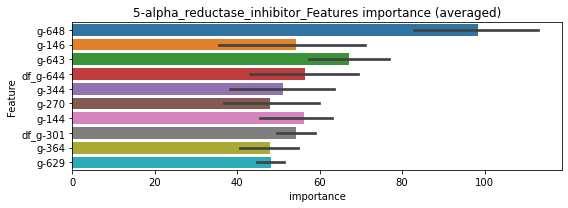

len(train_index) : 3780
len(valid_index) : 3780
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00650208	valid_1's binary_logloss: 0.0194766


len(train_index) : 3780
len(valid_index) : 3780
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.00130365	valid_1's binary_logloss: 0.0141923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00649594	valid_1's binary_logloss: 0.013207
[200]	training's binary_logloss: 0.000846613	valid_1's binary_logloss: 0.00603835
[300]	training's binary_logloss: 0.000284546	valid_1's binary_logloss: 0.00485966
[400]	training's binary_logloss: 0.000171014	valid_1's binary_logloss: 0.00445588
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000160213	valid_1's binary_logloss: 0.00443522


5-alpha_reductase_inhibitor logloss: 0.00931373799853194
11-beta-hsd1_inhibitor , len(trt) : 18


neg labels: 3289→ selected neg labels: 3286


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016486	valid_1's binary_logloss: 0.0328989
[200]	training's binary_logloss: 0.00234636	valid_1's binary_logloss: 0.0136812
[300]	training's binary_logloss: 0.000772361	valid_1's binary_logloss: 0.00876114
[400]	training's binary_logloss: 0.000442819	valid_1's binary_logloss: 0.00731846
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000376914	valid_1's binary_logloss: 0.00681292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169427	valid_1's binary_logloss: 0.0291112
[200]	training's binary_logloss: 0.00237343	valid_1's binary_logloss: 0.00884414
[300]	training's binary_logloss: 0.00078023	valid_1's binary_logloss: 0.00496793
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000559572	valid_1's binary_logloss: 0.00434652


1 / 3 AUC score:1.000
Threshold: 0.005534050107441619
Remove_noisy_labels: 34 → positive_corect_labels: 328/3580
30th percentile: 0.00016
p_label_rate: 0.00954 Vs.target_rate: 0.00098, Num_p_label: 38.0, conf_0:0.00016, conf_1:0.01761
Num_p_label: 38.0, Expected: 3.9, Adj_threshold_1: 0.01
Num_p_label: 0.0, Expected: 3.9, Adj_threshold_2: 0.05
threshold:0.05, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:328.0/3580, y_label_rate: 0.09162
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162578	valid_1's binary_logloss: 0.0339723
[200]	training's binary_logloss: 0.00233214	valid_1's binary_logloss: 0.0148266
[300]	training's binary_logloss: 0.000763333	valid_1's binary_logloss: 0.00952041
[400]	training's binary_logloss: 0.000440462	valid_1's binary_logloss: 0.0080652
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000376257	valid_1's binary_logloss: 0.00767032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169676	valid_1's binary_logloss: 0.0264476
[200]	training's binary_logloss: 0.0023386	valid_1's binary_logloss: 0.00666358
[300]	training's binary_logloss: 0.000758311	valid_1's binary_logloss: 0.00383396


2 / 3 AUC score:1.000
Threshold: 0.04553405010744162


[400]	training's binary_logloss: 0.000436467	valid_1's binary_logloss: 0.00317419
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000451591	valid_1's binary_logloss: 0.0031726


Remove_noisy_labels: 0 → positive_corect_labels: 328.0/3580
30th percentile: 0.00014
p_label_rate: 0.00000 Vs.target_rate: 0.00098, Num_p_label: 0.0, conf_0:0.00014, conf_1:0.04553
Num_p_label: 0.0, Expected: 3.9, Adj_threshold_1: 0.05
threshold:0.01, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:328.0/3580, y_label_rate: 0.09162
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162578	valid_1's binary_logloss: 0.0339723
[200]	training's binary_logloss: 0.00233214	valid_1's binary_logloss: 0.0148266
[300]	training's binary_logloss: 0.000763333	valid_1's binary_logloss: 0.00952041
[400]	training's binary_logloss: 0.000440462	valid_1's binary_logloss: 0.0080652
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000376257	valid_1's binary_logloss: 0.00767032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169676	valid_1's binary_logloss: 0.0264476
[200]	training's binary_logloss: 0.0023386	valid_1's binary_logloss: 0.00666358
[300]	training's binary_logloss: 0.000758311	valid_1's binary_logloss: 0.00383396


3 / 3 AUC score:1.000
Threshold: 0.005534050107441617


[400]	training's binary_logloss: 0.000436467	valid_1's binary_logloss: 0.00317419
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000451591	valid_1's binary_logloss: 0.0031726


Remove_noisy_labels: 25 → positive_corect_labels: 328.0/3555
30th percentile: 0.00014
p_label_rate: 0.00979 Vs.target_rate: 0.00098, Num_p_label: 39.0, conf_0:0.00014, conf_1:0.02079
Num_p_label: 39.0, Expected: 3.9, Adj_threshold_1: 0.01
Num_p_label: 0.0, Expected: 3.9, Adj_threshold_2: 0.05
threshold:0.05, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:328.0/7537, y_label_rate: 0.04352


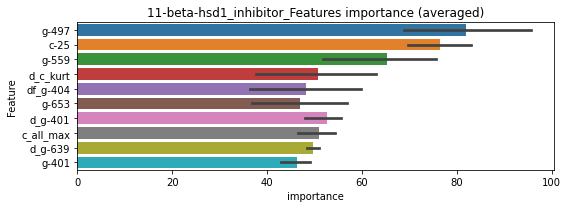

len(train_index) : 3768
len(valid_index) : 3769
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00802311	valid_1's binary_logloss: 0.0173304
[200]	training's binary_logloss: 0.00112577	valid_1's binary_logloss: 0.006621
[300]	training's binary_logloss: 0.000359068	valid_1's binary_logloss: 0.00402969
[400]	training's binary_logloss: 0.000201909	valid_1's binary_logloss: 0.00322226
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000173104	valid_1's binary_logloss: 0.00298986


len(train_index) : 3769
len(valid_index) : 3768
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00825673	valid_1's binary_logloss: 0.0144351
[200]	training's binary_logloss: 0.00115777	valid_1's binary_logloss: 0.00398881
[300]	training's binary_logloss: 0.000363046	valid_1's binary_logloss: 0.00230196
[400]	training's binary_logloss: 0.000205271	valid_1's binary_logloss: 0.00190739
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000200264	valid_1's binary_logloss: 0.00187697


11-beta-hsd1_inhibitor logloss: 0.002433486702319096
acat_inhibitor , len(trt) : 24


neg labels: 3289→ selected neg labels: 3285


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223951	valid_1's binary_logloss: 0.0394519
[200]	training's binary_logloss: 0.0034043	valid_1's binary_logloss: 0.0125851
[300]	training's binary_logloss: 0.00108212	valid_1's binary_logloss: 0.00694623
[400]	training's binary_logloss: 0.000581742	valid_1's binary_logloss: 0.00513725
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000517809	valid_1's binary_logloss: 0.00494294
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212541	valid_1's binary_logloss: 0.0439502
[200]	training's binary_logloss: 0.00349295	valid_1's binary_logloss: 0.0134978
[300]	training's binary_logloss: 0.00108601	valid_1's binary_logloss: 0.00731831
[400]	training's binary_logloss: 0.000575017	valid_1's binary_logloss: 0.00535554
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000488132	valid_1's binary_logloss: 0.00513739


1 / 3 AUC score:1.000
Threshold: 0.004472865870108365
Remove_noisy_labels: 34 → positive_corect_labels: 328/3579
30th percentile: 0.00022
p_label_rate: 0.00703 Vs.target_rate: 0.00125, Num_p_label: 28.0, conf_0:0.00022, conf_1:0.01315
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_1: 0.00
Num_p_label: 0.0, Expected: 5.0, Adj_threshold_2: 0.04
threshold:0.04, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:328.0/3579, y_label_rate: 0.09165
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215953	valid_1's binary_logloss: 0.0377117
[200]	training's binary_logloss: 0.00335666	valid_1's binary_logloss: 0.0120876
[300]	training's binary_logloss: 0.00107366	valid_1's binary_logloss: 0.00656457
[400]	training's binary_logloss: 0.000577811	valid_1's binary_logloss: 0.0048008
[500]	training's binary_logloss: 0.000439297	valid_1's binary_logloss: 0.00437406
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000447141	valid_1's binary_logloss: 0.00433562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206349	valid_1's binary_logloss: 0.042581



KeyboardInterrupt: 

In [50]:
categorical_cols = []
feature_importance_df = pd.DataFrame()
importance_cols_df = pd.DataFrame()
scores = []
models = []

for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models, _feature_importance_df = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    if DEBUG:
        if _score > 0.02:
            importance_cols_df[target_col] = select_importance_cols(_feature_importance_df)
            print(importance_cols_df)
        
        feature_importance_df = create_featureimprotance(models, feature_importance_df)

In [ ]:
sub.to_csv('submission.csv', index=False)

In [ ]:
print(f"CV:{np.mean(scores)}")

In [ ]:
if DEBUG:
    show_feature_importance(feature_importance_df)
    feature_importance_df.to_csv(f'feature_importance_df.{Version}.csv', index=False)
    importance_cols_df.to_csv(f'importance_cols_df.{Version}.csv', index=False)